In [5]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Load datasets
customers = pd.read_csv('/content/drive/My Drive/Customers.csv')
products = pd.read_csv('/content/drive/My Drive/Products.csv')
transactions = pd.read_csv('/content/drive/My Drive/Transactions.csv')

# Check the data
print("Customers Data:")
print(customers.head())

print("\nProducts Data:")
print(products.head())

print("\nTransactions Data:")
print(transactions.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Customers Data:
  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15

Products Data:
  ProductID              ProductName     Category   Price
0      P001     ActiveWear Biography        Books  169.30
1      P002    ActiveWear Smartwatch  Electronics  346.30
2      P003  ComfortLiving Biography        Books   44.12
3      P004            BookWorld Rug   Home Decor   95.69
4      P005          TechPro T-Shirt     Clothing  429.31

Transactions Data:
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  20

Missing Values in Customers:
CustomerID      0
CustomerName    0
Region          0
SignupDate      0
dtype: int64

Missing Values in Products:
ProductID      0
ProductName    0
Category       0
Price          0
dtype: int64

Missing Values in Transactions:
TransactionID      0
CustomerID         0
ProductID          0
TransactionDate    0
Quantity           0
TotalValue         0
Price              0
dtype: int64


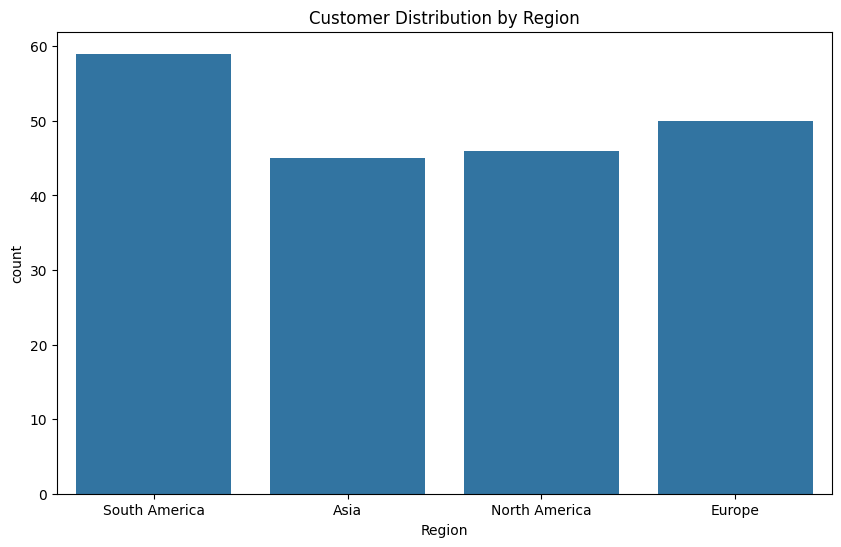

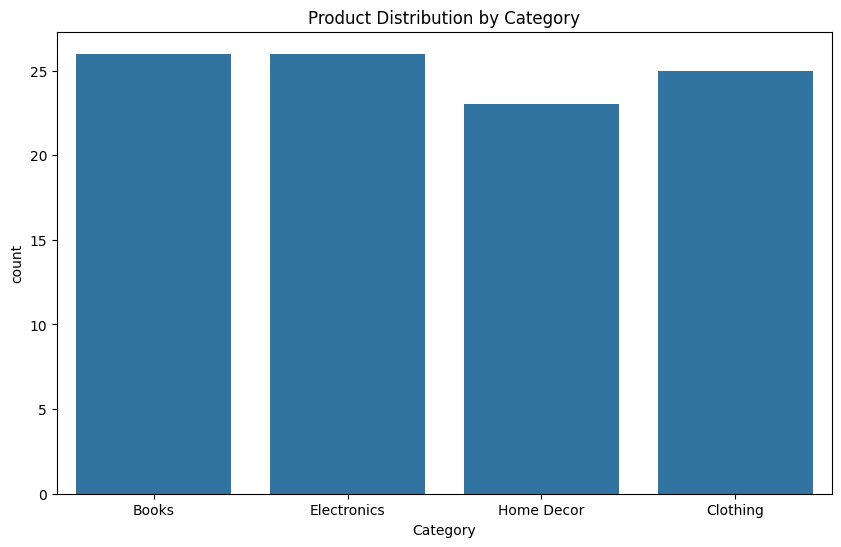

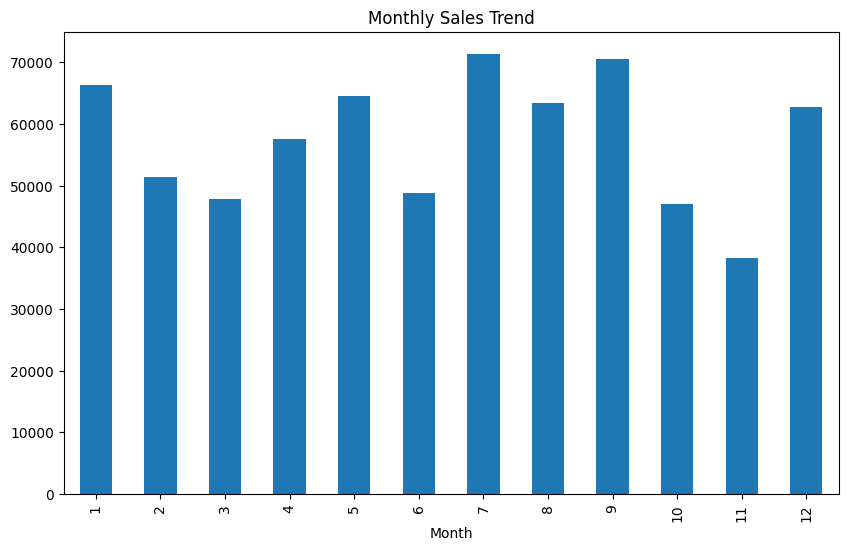

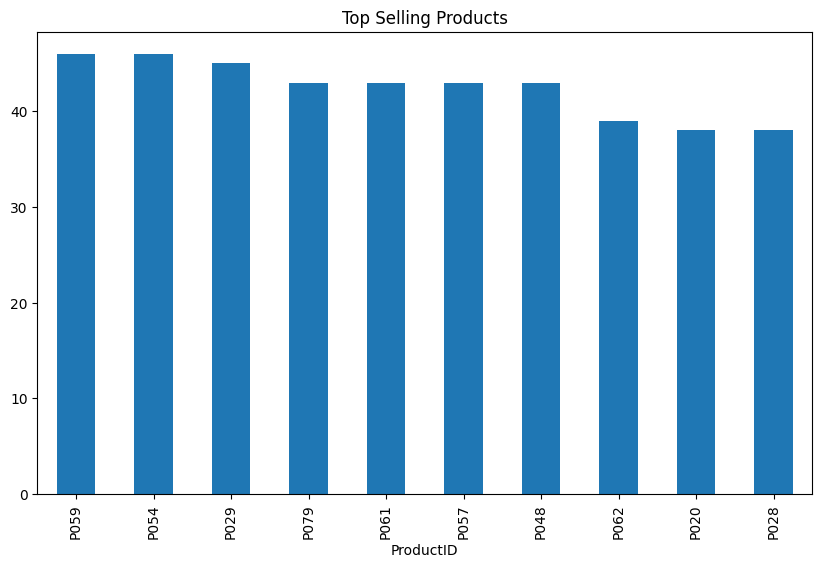

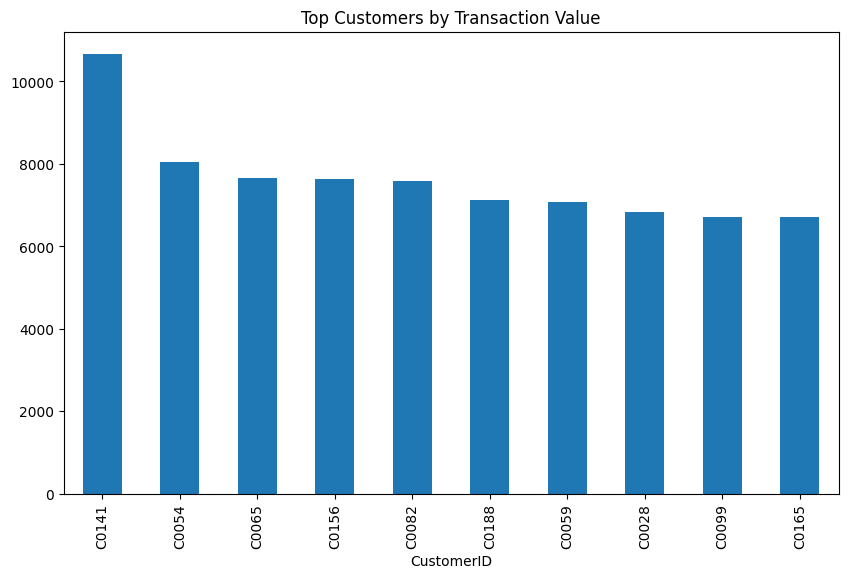

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Check for missing values
print("Missing Values in Customers:")
print(customers.isnull().sum())

print("\nMissing Values in Products:")
print(products.isnull().sum())

print("\nMissing Values in Transactions:")
print(transactions.isnull().sum())

# Distribution of customers by region
plt.figure(figsize=(10, 6))
sns.countplot(data=customers, x='Region')
plt.title('Customer Distribution by Region')
plt.show()

# Distribution of products by category
plt.figure(figsize=(10, 6))
sns.countplot(data=products, x='Category')
plt.title('Product Distribution by Category')
plt.show()

# Transaction trends over time
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])
transactions['Month'] = transactions['TransactionDate'].dt.month
monthly_sales = transactions.groupby('Month')['TotalValue'].sum()
plt.figure(figsize=(10, 6))
monthly_sales.plot(kind='bar')
plt.title('Monthly Sales Trend')
plt.show()

# Top-selling products
top_products = transactions.groupby('ProductID')['Quantity'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
top_products.plot(kind='bar')
plt.title('Top Selling Products')
plt.show()

# Customers with highest transaction values
top_customers = transactions.groupby('CustomerID')['TotalValue'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
top_customers.plot(kind='bar')
plt.title('Top Customers by Transaction Value')
plt.show()

In [7]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

# Merge datasets
customer_transactions = pd.merge(transactions, customers, on='CustomerID')
customer_profile = customer_transactions.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum',
    'ProductID': 'nunique'
}).reset_index()

# Normalize features
scaler = StandardScaler()
customer_profile_scaled = scaler.fit_transform(customer_profile[['TotalValue', 'Quantity', 'ProductID']])

# Calculate similarity matrix
similarity_matrix = cosine_similarity(customer_profile_scaled)

# Function to get top 3 similar customers
def get_top_similar_customers(customer_id, similarity_matrix, top_n=3):
    customer_index = customer_profile[customer_profile['CustomerID'] == customer_id].index[0]
    similarities = similarity_matrix[customer_index]
    top_indices = similarities.argsort()[-top_n-1:-1][::-1]
    top_customers = customer_profile.iloc[top_indices]['CustomerID'].tolist()
    top_scores = similarities[top_indices].tolist()
    return list(zip(top_customers, top_scores))

# Generate lookalike recommendations for first 20 customers
lookalike_map = {}
for customer_id in customer_profile['CustomerID'][:20]:
    lookalike_map[customer_id] = get_top_similar_customers(customer_id, similarity_matrix)

# Save to CSV
lookalike_df = pd.DataFrame(lookalike_map.items(), columns=['CustomerID', 'Lookalikes'])
lookalike_df.to_csv('/content/drive/My Drive/FirstName_LastName_Lookalike.csv', index=False)

print("Lookalike recommendations saved to Google Drive!")

Lookalike recommendations saved to Google Drive!


Davies-Bouldin Index: 0.8956923630972515


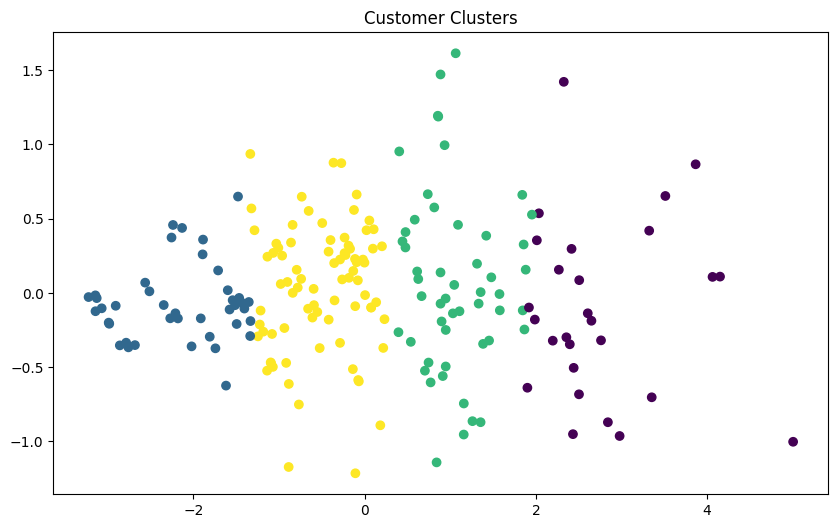

In [8]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score

# Perform K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
customer_profile['Cluster'] = kmeans.fit_predict(customer_profile_scaled)

# Calculate DB Index
db_index = davies_bouldin_score(customer_profile_scaled, customer_profile['Cluster'])
print(f'Davies-Bouldin Index: {db_index}')

# Visualize clusters using PCA
pca = PCA(n_components=2)
customer_profile_pca = pca.fit_transform(customer_profile_scaled)
plt.figure(figsize=(10, 6))
plt.scatter(customer_profile_pca[:, 0], customer_profile_pca[:, 1], c=customer_profile['Cluster'], cmap='viridis')
plt.title('Customer Clusters')
plt.show()